# Popular Data Science Questions

# Stack Exchange

What is it that people want to learn about data science?

To answer this question we will explore Stack Exchange, so that we can get a feel as to what types of questions are relevant.

What kind of questions are welcome on this site?
 - Apparently based on exploration, the types of questions in the [Data Science Stack Exchange](https://datascience.stackexchange.com/) are mostly questions about a certain problem a data scientist may have encountered some are career related questions and etc.

It has a very similar feel to stackoverflow.

Other Subdivisions?
- There is tags, unanswered questions, jobs and users.
- the questions portion is very useful and some of the unanswered questions.

Info in posts?
- votes, answers, views and the question itself.

# Stack Exchange Data Explorer

We will be using Microsoft SQL in this project as this is what is being used by stack exchange.

https://data.stackexchange.com/datascience/query/edit/1350346

We will be doing queries in Stack Exchange's data explorer.

- Tags, posts, users and possibly votes seem to be quite interesting tables. These tables can help answer which content are popular.


# Getting the Data

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:

- `Id`: An identification number for the post.
- `PostTypeId`: An identification number for the type of post.
- `CreationDate`: The date and time of creation of the post.
- `Score`: The post's score.
- `ViewCount`: How many times the post was viewed.
- `Tags`: What tags were used.
- `AnswerCount`: How many answers the question got (only applicable to question posts).
- `FavoriteCount`: How many times the question was favored (only applicable to question posts).

We will have to focus on questions as other posts seem to be outliers because of how low their volumes are.

Since we're only interested in recent posts, we'll limit our analysis to the posts of 2019. (At the time of writing it is early 2020).

QUERY:

SELECT 
  Id, 
  PostTypeId, 
  CreationDate, 
  Score, 
  ViewCount, 
  Tags, 
  AnswerCount,
  FavoriteCount
FROM posts
WHERE 
  YEAR(CreationDate) = 2019
  AND PostTypeId = 1;

# Exploring the Data

In [1]:
import pandas as pd

df = pd.read_csv('2019_questions.csv')
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


In [3]:
null_values = 8839 - df['FavoriteCount'].count()
print(df['FavoriteCount'].count())
print('There are ' + str(null_values) + ' Null Values in FavoriteCount')

1407
There are 7432 Null Values in FavoriteCount


- How many missing values are there in each column?

All columns are complete except FavoriteCount which has 7432 Null Values. This is quite substantial loss of data for the column.

- Can we fix the missing values somehow?

Since the number of null values is substantial, I donot think we can remedy this properly.

- Are the types of each column adequate?

Based on info the types of each column seem to be adequate enough to perform analytics.

- What can we do about the Tags column?

We can use str.replace to remove the <> symbols with a regex or simple definition. use , with separator to create a list.

# Cleaning the Data

We will now perform some cleaning on the retrieved data from Stack Exchange.

Prescribed Data Types for each column:

- Id                        int64
- CreationDate     datetime64[ns]
- Score                     int64
- ViewCount                 int64
- Tags                     object
- AnswerCount               int64
- FavoriteCount             int64

In [4]:
# Set all 1407 null values to 0.
df['FavoriteCount'] = df['FavoriteCount'].fillna(0)

In [5]:
# Set the types of each column as prescribed.
df['CreationDate'] = df['CreationDate'].astype('datetime64[ns]')
df['FavoriteCount'] = df['FavoriteCount'].astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


In [7]:
# Clean the tags column
df["Tags"] = df["Tags"].str.replace("^<|>$", "").str.split("><")

In [8]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0


# Most Used and Most Viewed

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [9]:
# count how many times each tag was used.
tag_count = {}

for ls in df['Tags']:
    for t in ls:
        if t in tag_count:
            tag_count[t] += 1
        else:
            tag_count[t] = 1

In [10]:
print(tag_count)

{'convnet': 111, 'ibm-watson': 1, 'regex': 8, 'feature-selection': 209, 'machine-learning-model': 224, 'learning-rate': 8, 'r': 268, 'structured-data': 5, 'nl2sql': 1, 'text-generation': 17, 'representation': 9, 'batch-normalization': 29, 'similar-documents': 20, 'collinearity': 6, 'anomaly': 4, 'genetic-programming': 2, 'matplotlib': 77, 'dataframe': 81, 'svm': 136, 'manhattan': 3, 'policy-gradients': 27, 'data-wrangling': 15, 'predictive-modeling': 265, 'books': 7, 'text-mining': 113, 'feature-construction': 16, 'education': 3, 'distance': 44, 'automl': 2, 'self-driving': 3, 'neural-network': 1055, 'cosine-distance': 21, 'multi-instance-learning': 2, 'linear-regression': 175, 'open-set': 2, 'fuzzy-logic': 13, 'anomaly-detection': 92, 'categories': 2, 'model-selection': 58, 'theory': 11, 'word-embeddings': 117, 'mean-shift': 2, 'supervised-learning': 82, 'ab-test': 6, 'heatmap': 9, 'scikit-learn': 540, 'visualization': 126, 'natural-language-process': 124, 'feature-extraction': 87, 'd

In [11]:
# Transform dictionary to dataframe for ease of analytics
tag_count = pd.DataFrame.from_dict(tag_count, orient = 'index')

In [12]:
tag_count

,0
convnet,111
ibm-watson,1
regex,8
feature-selection,209
machine-learning-model,224
learning-rate,8
r,268
structured-data,5
nl2sql,1
text-generation,17


In [13]:
tag_count.rename(columns = {0:'Count'}, inplace = True)

In [14]:
tag_count.head()

,Count
convnet,111
ibm-watson,1
regex,8
feature-selection,209
machine-learning-model,224


In [15]:
most_used = tag_count.sort_values('Count').tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


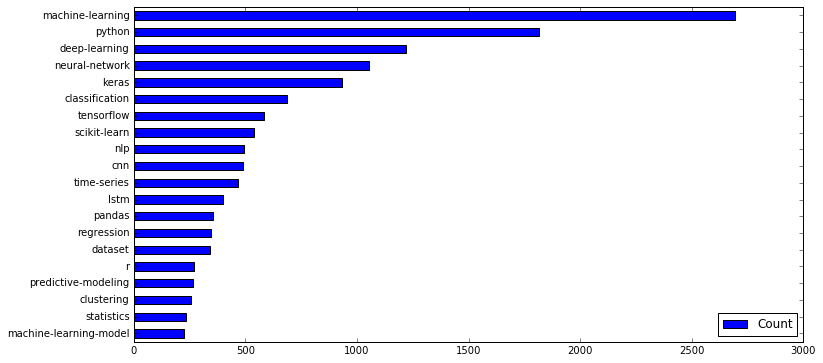

In [16]:
%matplotlib inline
most_used.plot(kind = 'barh', figsize = (12,6))

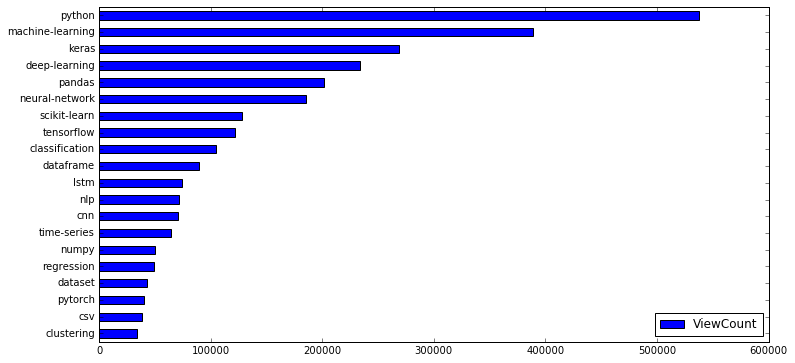

In [17]:
# count how many times each tag was viewed.
tag_views = {}

for index, row in df.iterrows():
    for t in row['Tags']:
        if t in tag_views:
            tag_views[t] += row['ViewCount']
        else:
            tag_views[t] = row['ViewCount']
            
# Transform dictionary to dataframe for ease of analytics
tag_views = pd.DataFrame.from_dict(tag_views, orient = 'index')
tag_views.rename(columns = {0:'ViewCount'}, inplace = True)

most_viewed = tag_views.sort_values('ViewCount').tail(20)
most_viewed.plot(kind = 'barh', figsize = (12,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2a7055f8>],
      dtype=object)

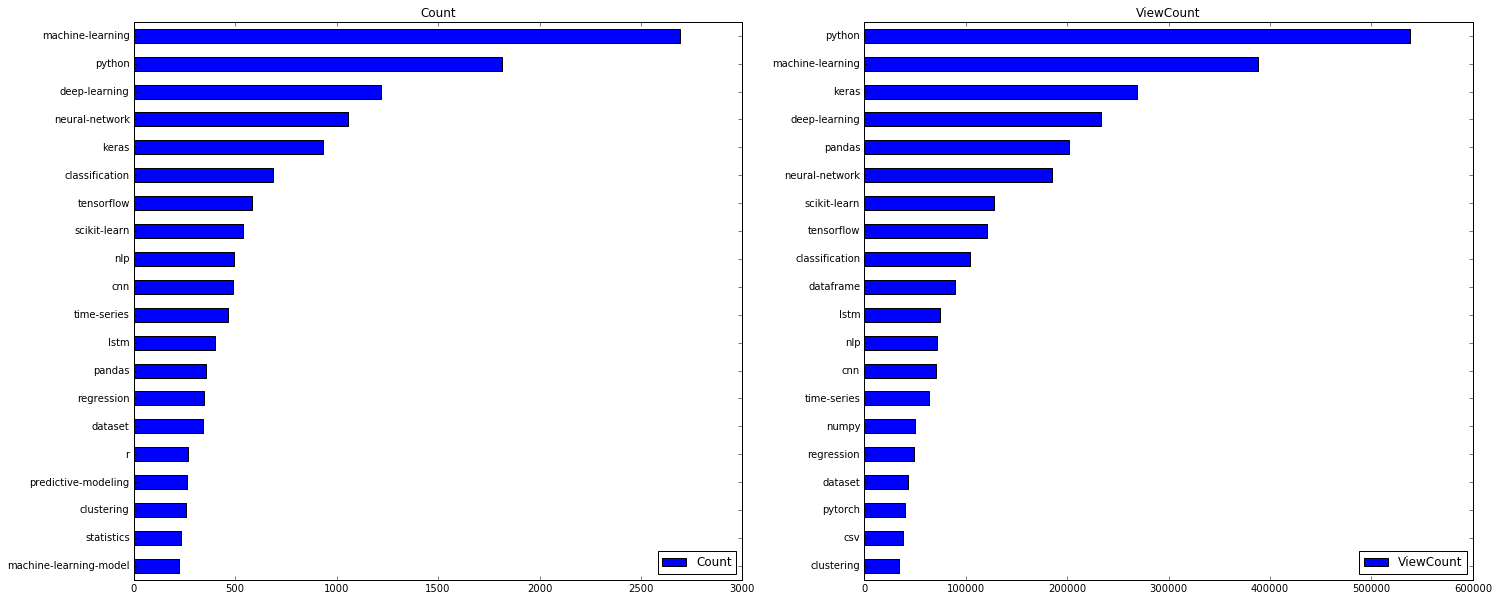

In [18]:
# side by side comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

# Relations Between Tags

The goal in this section is to find a technical solution to determining how tags are related. 

In [19]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used

,Count,ViewCount
machine-learning-model,224,NaN
statistics,234,NaN
clustering,257,33928.0
predictive-modeling,265,NaN
r,268,NaN
dataset,340,43151.0
regression,347,49451.0
pandas,354,201787.0
lstm,402,74458.0
time-series,466,64134.0


In [20]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed

,Count,ViewCount
clustering,257.0,33928
csv,NaN,38654
pytorch,NaN,40240
dataset,340.0,43151
regression,347.0,49451
numpy,NaN,49767
time-series,466.0,64134
cnn,489.0,70349
nlp,493.0,71382
lstm,402.0,74458


In [21]:
# R and pandas are definitely not related
df[df["Tags"].apply(
    lambda tags: True if "r" in tags and "pandas" in tags else False)
]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
2873,60074,2019-09-11 20:35:17,0,22,"[r, pandas, dplyr]",0,0
3651,49148,2019-04-11 19:41:39,1,83,"[r, data-mining, pandas, matlab, databases]",3,0


The tags present in most_used and not present in most_viewed are:

- machine-learning-model
- statistics
- predictive-modeling
- r

And the tags present in most_viewed but not in most_used are:

- csv
- pytorch
- dataframe

- A way to find relationships between pairs of tags is probably to use correlational coefficients or covariance.

- For multiple tags perhaps using Correlational Coefficients or Covariance of multiple variables. Which are quite complex statistical concepts.

- These are just some ideas, although Correlational coefficients may be the most related to finding the relationships between tags.

- These methods may be very powerful but the problem might be solved in a much more practical way than going into a very fine analysis into each tag.

# Domain Knowledge

Instead of going the complex statistical analytics route we may be able to solve the problem of finding the relationships between tags by a more practical method such as gathering Domain information through a good old web search and a bit of SQL exploration in the Stack Exchange site.

- keras, tensorflow and scikit-learn are all Python Machine learning and Deep learning libraries.

- The other terms Machine learning, deep learning are related to these libraries as these libraries solve these concepts.

- Neural networks are a type of deep learning algorithm that can be utilized in relation to the libraries above.

- classification is another type of machine learning library that can once again be solved by one or more of the libraries above.

# Just a Fad?

"Is deep learning just a fad?" Could interest in deep learning be slowing down? 

In this we will track the interest in deep learning across time. We will:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

In [22]:
# Read file
df_all_q = pd.read_csv('all_questions.csv', parse_dates=["CreationDate"])

In [23]:
df_all_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null datetime64[ns]
Tags            21576 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


In [24]:
df_all_q['Tags']

0            <python><keras><tensorflow><cnn><probability>
1                                         <neural-network>
2                            <python><ibm-watson><chatbot>
3                                                  <keras>
4        <r><predictive-modeling><machine-learning-mode...
5                                                    <cnn>
6                             <machine-learning><learning>
7                                       <machine-learning>
8                        <python><keras><tensorflow><lstm>
9                 <neural-network><feature-selection><mlp>
10               <predictive-modeling><recommender-system>
11                         <python><classification><keras>
12                                <python><neural-network>
13                                      <python><anaconda>
14          <python><neural-network><deep-learning><keras>
15                   <python><scikit-learn><random-forest>
16       <data-mining><time-series><lstm><rnn><data-cle.

In [25]:
# Transform the tags column
df_all_q["Tags"] = df_all_q["Tags"].str.replace("^<|>$", "").str.split("><")

In [26]:
df_all_q['Tags']

0            [python, keras, tensorflow, cnn, probability]
1                                         [neural-network]
2                            [python, ibm-watson, chatbot]
3                                                  [keras]
4        [r, predictive-modeling, machine-learning-mode...
5                                                    [cnn]
6                             [machine-learning, learning]
7                                       [machine-learning]
8                        [python, keras, tensorflow, lstm]
9                 [neural-network, feature-selection, mlp]
10               [predictive-modeling, recommender-system]
11                         [python, classification, keras]
12                                [python, neural-network]
13                                      [python, anaconda]
14          [python, neural-network, deep-learning, keras]
15                   [python, scikit-learn, random-forest]
16       [data-mining, time-series, lstm, rnn, data-cle.

In [27]:
# Think about what questions should be classified as deep learning questions and the implement that definition.
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

In [28]:
df_all_q['DeepLearning'] = df_all_q['Tags'].apply(class_deep_learning)

In [29]:
df_all_q[df_all_q['CreationDate'].dt.year == 2020]

,Id,CreationDate,Tags,DeepLearning
20304,65678,2020-01-01 01:07:22,"[machine-learning, deep-learning, data-mining,...",1
20305,65680,2020-01-01 07:53:47,"[python, k-means, image-segmentation]",0
20306,65684,2020-01-01 11:27:44,"[r, random-forest, bigdata]",0
20307,65686,2020-01-01 13:56:11,"[computer-vision, image-recognition, vae]",0
20308,65688,2020-01-01 16:17:40,"[machine-learning, neural-network, deep-learni...",1
20309,65689,2020-01-01 16:21:10,"[scikit-learn, pipelines]",1
20310,65691,2020-01-01 16:39:17,"[classification, scikit-learn]",1
20311,65692,2020-01-01 16:56:36,"[classification, predictive-modeling]",0
20312,65693,2020-01-01 17:03:52,"[classification, dataset, labels, separable]",0
20313,65696,2020-01-01 19:12:38,"[machine-learning, classification, dataset, li...",0


As we can observe 2020 dates are not yet completed as of the retrieval of this dataset. Therefore we will remove 2020 data first to be able to perform a more accurate analysis.

In [30]:
df_all_q = df_all_q[df_all_q['CreationDate'].dt.year < 2020]

In [31]:
# we will check Deep learning interest by Quarter.
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

df_all_q["Quarter"] = df_all_q["CreationDate"].apply(fetch_quarter)

In [32]:
df_all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


For final step we'll group by quarter and:

- Count the number of deep learning questions.
- Count the total number of questions.
- Compute the ratio between the two numbers above.

In [37]:
quarterly = df_all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly['DeepLearningQuestions'] / quarterly['TotalQuestions']

# for visualizations later.
quarterly.reset_index(inplace=True)
quarterly.head(20)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222
3,15Q1,18,190,0.094737
4,15Q2,28,284,0.098592
5,15Q3,45,311,0.144695
6,15Q4,66,382,0.172775
7,16Q1,110,516,0.213178
8,16Q2,109,518,0.210425
9,16Q3,161,585,0.275214


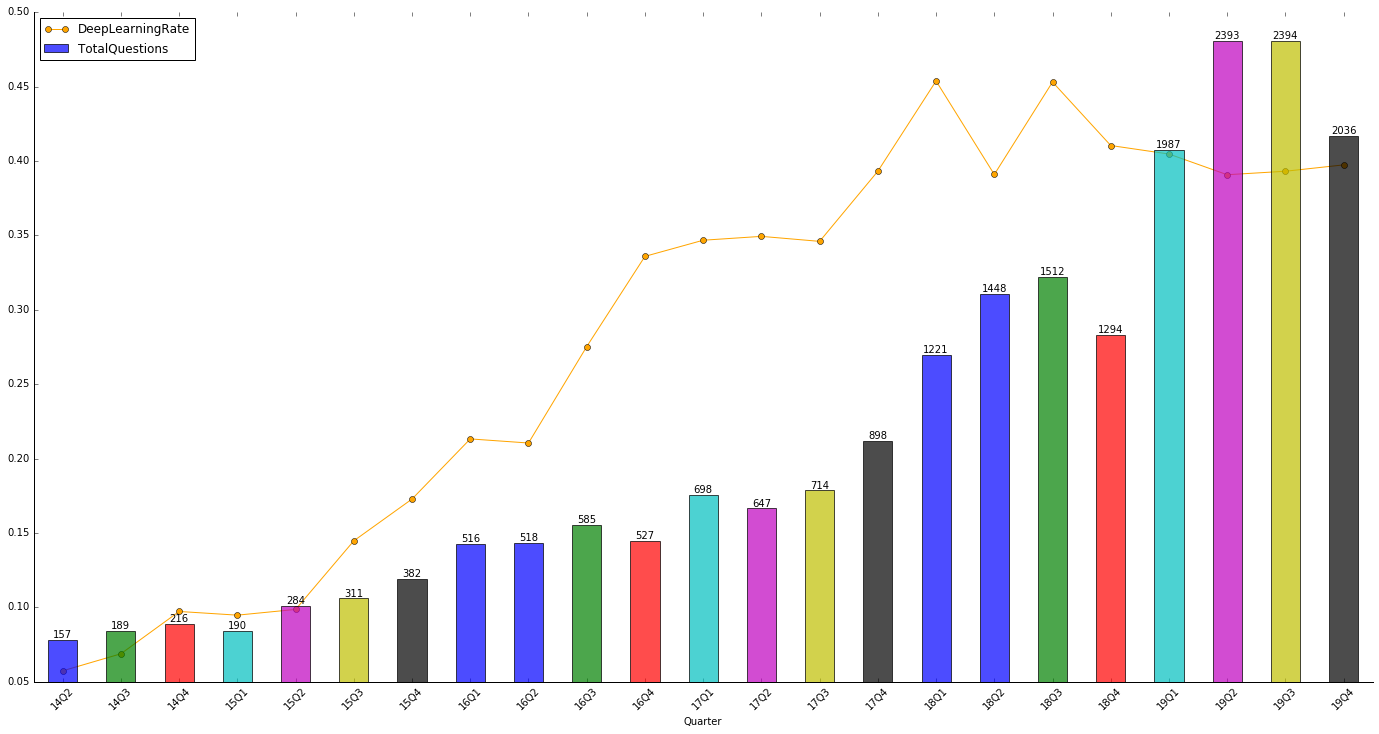

In [38]:
# Visualization
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)


interest in deep learning content seems to be growing at a steady rate since the establishment of Data Science Stack Exchange. Although interest seemed to stop for a bit which ended in a plateau.

Although with current trends in Machine Learning and Deep Learning and with all the current news and social media posts revolving around this subject I think interest in Deep learning may just keep going upward and 2020 will surely exhibit such trend.